# Cargamos interacciones etiquetadas

In [1]:
import pandas as pd

df_interaction_labels = pd.read_json("./data/covid_twitter_sample_2020-04-16_interactions_labeled_chatgpt_revised_full.json")
df_interaction_labels.shape

(970, 4)

In [2]:
df_interaction_labels.columns

Index(['tweet1', 'tweet2', 'razonamiento', 'etiqueta'], dtype='object')

In [3]:
df_interactions = pd.read_csv("data/covid_twitter_sample_2020-04-16_interactions.csv")
df_interactions.columns

Index(['created_date', 'topic', 'topic_prob', 'original_created',
       'original_tweet_id', 'original_tweet_text', 'original_user_id',
       'reply_created', 'reply_tweet_id', 'reply_text', 'reply_user_id'],
      dtype='object')

In [4]:
df_interaction_labels = df_interaction_labels.merge(
    df_interactions[['original_tweet_id', 'original_tweet_text', 'reply_tweet_id', 'reply_text', 'topic', 'topic_prob']],
    left_on=["tweet1", "tweet2"],
    right_on=['original_tweet_text', "reply_text"],
    how="inner")

In [5]:
df_interaction_labels.shape

(970, 10)

In [6]:
df_originals = df_interaction_labels[["original_tweet_id", "original_tweet_text"]].rename(
    columns={"original_tweet_id": "tweet_id", "original_tweet_text": "full_text"}
).drop_duplicates()

df_replies = df_interaction_labels[["reply_tweet_id", "reply_text"]].rename(
        columns={"reply_tweet_id": "tweet_id", "reply_text": "full_text"}
    )

df_single_tuits = pd.concat([df_originals, df_replies]).drop_duplicates()

In [7]:
df_single_tuits.shape

(1110, 2)

In [8]:
df_tuit_ids = df_single_tuits.tweet_id.values.tolist()

In [9]:
len(df_tuit_ids)

1110

# Generamos _features_
Inspiradas en el trabajo
[Explotando características contextuales para la detección de posturas en Twitter en el marco de la vacunación del COVID-19 en Argentina.](https://docs.google.com/document/d/10kzaOA857nJynijoRkFd9J-OuBVBsMphwoVQr7EiRs8/edit?usp=sharing)

(Trabajo Especial de Licenciatura en Ciencias de la Computación, , FaMAF, UNC. Mariano Schmidt (2021))


## Sociales
Para cada tweet y su respuesta, extraemos las siguientes features de actividad social:

- Cantidad de Retweets: Número de retweets que tiene el tweet analizado.
- Cantidad de Replies
- Cantidad de Likes
- Es cita: Si el tweet analizado es una cita de otro tweet.
- Cantidad de citas al tuit analizado.


In [ ]:
from pymongo import MongoClient

In [ ]:
client = MongoClient()
db = client["twits_db"]
db.list_collection_names()
col = db["db.5e8fc63ddd8efca7e56c3215"]

In [ ]:
from datetime import datetime
start_ts = datetime.fromisoformat('2020-04-12T00:00:00+00:00')
end_ts =  datetime.fromisoformat('2020-04-19T00:00:00+00:00')

In [ ]:
col.find_one()

In [ ]:
df_single_tuits["tweet_id"].values.tolist()

In [ ]:
pipeline = [
    {
        '$project': {
            "id": 1,
            "_id": 0,
            'created_at': {
                '$dateFromString': {
                    'dateString': '$created_at'
                }
            },
            'is_quote_status': 1,
            'quote_count': 1,
            'reply_count': 1,
            'retweet_count': 1,
            'favorite_count': 1,
            'favorited': 1,
            'retweeted': 1
        }
    },
    {
        '$match': {
            "created_at": {"$gte": start_ts, "$lt": end_ts},
            "id": {"$in": df_single_tuits["tweet_id"].values.tolist()}
        }
    }
]

cursor = col.aggregate(pipeline)
social_feats_rows = []
for doc in cursor:
    del doc["created_at"]
    social_feats_rows.append(doc)

social_feats_df = pd.DataFrame(social_feats_rows)

In [16]:
social_feats_df.shape

(1110, 8)

In [ ]:
social_feats_df.to_csv("data/social_features.csv", index=False)

In [10]:
social_feats_df = pd.read_csv("data/social_features.csv")

In [11]:
social_feats_df.shape

(1110, 8)

In [12]:
social_feats_df.rename(columns={"id": "tweet_id"}, inplace=True)

In [13]:
social_feats_df.columns

Index(['tweet_id', 'is_quote_status', 'quote_count', 'reply_count',
       'retweet_count', 'favorite_count', 'favorited', 'retweeted'],
      dtype='object')

## Estructurales
Para cada tweet y su respuesta, generamos las siguientes features estructurales (Extraíbles del texto del tweet):

- Question Mark: Ocurrencia de al menos un signo de interrogación.
- Question Mark Count: Cantidad de signos de interrogación.
- Starts with Question Mark: El tweet empieza con al menos un signo de interrogación
- Ends with Mark Count: El tweet termina con al menos un signo de interrogación
- Upper Ratio: Ratio entre letras en mayúsculas vs letras totales en el texto
- Exclamation Mark: Ocurrencia de al menos un signo de admiración
- Exclamation Mark Count: Cantidad de signos de admiración
- Ellipsis Occurrence: Ocurrencia de 3 o más signos de “.” seguidos
- Hashtag Presence: Presencia de Hashtags.
- Text Length: Largo del texto sin la presencia de hashtags, urls, y cuentas de Twitter.
- URL Count: Cantidad de URLS en el texto.
- Quotes: texto tiene palabras encerradas entre comillas

In [14]:
def extract_structural_features(df, text_col='full_text', inplace=False):
    """
    Extract structural features from `text_col` in `df`.
    Returns dataframe (modified copy unless inplace=True) with new columns:
      - retweet_count, is_retweet
      - question_mark (bool), question_mark_count
      - starts_with_question_mark (bool), ends_with_question_mark (bool)
      - upper_ratio
      - exclamation_mark (bool), exclamation_mark_count
      - ellipsis_occurrence (bool)
      - hashtag_presence (bool)
      - text_length (chars after removing hashtags, urls, and handles)
      - url_count
      - quotes (bool)
    """
    if not inplace:
        df = df.copy()

    s = df[text_col].fillna('').astype(str)

    # Basic punctuation counts / indicators
    df['question_mark_count'] = s.str.count(r'\?') + s.str.count(r'¿')
    df['question_mark'] = df['question_mark_count'] > 0
    df['starts_with_question_mark'] = s.str.lstrip().str.startswith('?') | s.str.lstrip().str.startswith('¿')
    df['ends_with_question_mark'] = s.str.rstrip().str.endswith('?')

    df['exclamation_mark_count'] = s.str.count(r'!') + s.str.count(r'¡')
    df['exclamation_mark'] = df['exclamation_mark_count'] > 0

    # Ellipsis (3 or more dots)
    df['ellipsis_occurrence'] = s.str.contains(r'\.{3,}', regex=True)

    # Hashtags presence
    df['hashtag_presence'] = s.str.contains(r'#\w', regex=True)

    # URL count
    df['url_count'] = s.str.count(r'https?://\S+|www\.\S+')

    # Quotes presence (pairs of common quote characters)
    df['quotes'] = s.str.contains(r'["“”«»\'].*?["“”«»\']', regex=True)

    # Text length after removing hashtags, urls and twitter handles (@user)
    cleaned = s.str.replace(r'https?://\S+|www\.\S+|@\w+|#\w+', '', regex=True)
    df['text_length'] = cleaned.str.strip().str.len()
    df['text_word_count'] = cleaned.str.strip().replace(r'\s+', ' ', regex=True).str.split().map(lambda x: len(x) if isinstance(x, list) else 0)

    # Upper ratio: uppercase letters / total alphabetic letters
    def upper_ratio_fn(text):
        letters = [c for c in text if c.isalpha()]
        total_letters = len(letters)
        if total_letters == 0:
            return 0.0
        upper = sum(1 for c in letters if c.isupper())
        return upper / total_letters
    df['upper_ratio'] = s.map(upper_ratio_fn)

    return df

In [15]:
df_structural = extract_structural_features(df_single_tuits, text_col='full_text')

In [16]:
df_structural.shape

(1110, 15)


## Textuales

- Sentence embedding de tweet y respuesta (mismos que utilizamos para el modelado de temas).

In [17]:
import pandas as pd
import numpy as np

df_sample = pd.read_csv("data/covid_twitter_sample_2020-04-16.csv")
embeddings_sample = np.load(f"data/covid_twitter_sample_2020-04-16.npy")

In [18]:
df_sample.shape

(971679, 5)

In [19]:
embeddings_sample.shape

(971679, 384)

In [20]:
df_sample.columns

Index(['tweet_id', 'user_id', 'created_at', 'full_text', 'created_date'], dtype='object')

In [21]:
inds_in_sample = np.where(df_sample["tweet_id"].isin(df_tuit_ids))[0]

In [22]:
len(inds_in_sample)

882

In [23]:
embeddings_by_tweet_id = {
    df_sample["tweet_id"].values[ind]: embeddings_sample[i]
    for i, ind in enumerate(inds_in_sample)
}

In [24]:
len(embeddings_by_tweet_id)

882

In [25]:
# Agregamos embeddings para los tweets faltantes

In [26]:
from sentence_transformers import SentenceTransformer

embeddings_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

In [27]:
df_faltantes = df_single_tuits[
    ~df_single_tuits["tweet_id"].isin(embeddings_by_tweet_id.keys())
]

In [28]:
df_faltantes.shape

(228, 2)

In [29]:
embeddings_faltantes = embeddings_model.encode(df_faltantes["full_text"].values,
                                               batch_size=1024, show_progress_bar=True
                                               )

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
for i, tweet_id in enumerate(df_faltantes["tweet_id"]):
    embedding = embeddings_faltantes[i]
    embeddings_by_tweet_id[tweet_id] = embedding

In [31]:
len(embeddings_by_tweet_id)

1110

In [32]:
import pandas as pd
import numpy as np

def embeddings_dict_to_df(emb_dict, id_col='tweet_id', coord_prefix='dim', fill_missing=False):
    """
    Convert {id: embedding} -> DataFrame with first column `id_col` and remaining columns
    `coord_prefix_0`, `coord_prefix_1`, ...
    If `fill_missing` is True, embeddings with different lengths are padded with NaN.
    """
    if not emb_dict:
        return pd.DataFrame(columns=[id_col])

    # ensure consistent 2D array: list of arrays
    keys = list(emb_dict.keys())
    values = [np.asarray(emb_dict[k]) for k in keys]

    # check dims
    lengths = [v.shape[0] for v in values]
    if len(set(lengths)) != 1:
        if not fill_missing:
            raise ValueError("Embeddings have different lengths; set fill_missing=True to pad with NaN.")
        max_len = max(lengths)
        values = [np.pad(v, (0, max_len - v.shape[0]), constant_values=np.nan) for v in values]

    df = pd.DataFrame(values, index=keys)
    df.reset_index(inplace=True)
    df.rename(columns={'index': id_col}, inplace=True)

    n_coords = df.shape[1] - 1
    coord_names = [f"{coord_prefix}_{i}" for i in range(n_coords)]
    df.columns = [id_col] + coord_names

    return df

In [33]:
df_embeddings = embeddings_dict_to_df(embeddings_by_tweet_id)
df_embeddings.shape

(1110, 385)


## Conversacionales
- Levenhstein entre texto de tweet y respuesta
- Similaridad coseno entre tweet y respuesta (sentence embeddings)

In [34]:
# !pip install levenshtein

In [35]:
from Levenshtein import distance as levenshtein_distance
from sklearn.metrics.pairwise import cosine_similarity

df_interaction_labels["levehnstein"] = df_interaction_labels.apply(
    lambda row: levenshtein_distance(
        row["original_tweet_text"].lower(),
        row["reply_text"].lower()
    ),
    axis=1
)

df_interaction_labels["cosine_similarity"] = df_interaction_labels.apply(
    lambda row: cosine_similarity(
        embeddings_by_tweet_id[row["original_tweet_id"]].reshape(1, -1),
        embeddings_by_tweet_id[row["reply_tweet_id"]].reshape(1, -1)
    )[0, 0],
    axis=1
)

In [36]:
df_interaction_labels.shape

(970, 12)


## Afectivas

- Conteos de palabras afectivas (positivas, negativas) en tweet y respuesta (según léxico NRC en Español)

In [37]:
df_lex = pd.read_csv("data/lexico_nrc_es.csv")
lex_dict = {}

for _, row in df_lex.iterrows():
    palabra = row["palabra"]
    sentimiento = row["sentimiento"]
    if palabra not in lex_dict:
        lex_dict[palabra] = []
    lex_dict[palabra].append(sentimiento)

In [38]:
# import json
# with open("data/lexico_nrc_es.json", "w") as f:
#     json.dump(lex_json, f, ensure_ascii=False, indent=2)

In [39]:
import re

import unicodedata

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return str(only_ascii)

In [40]:
import spacy
import string

# Load the Spanish library from SpaCy
nlp = spacy.load("es_core_news_sm")

# Create list of punctuation marks
punctuations = string.punctuation

# Create list of stopwords from spaCy
es_stopwords = spacy.lang.es.stop_words.STOP_WORDS
es_stopwords = list(es_stopwords) + ["https", "http", "com", "covid", "covid19", "19", "co", "coronavirus", "rt"]

In [41]:
def count_nrc_sentiments(text, lexicon):
    text = text.lower()
    text = remove_accents(text)
    doc = nlp(text)
    tokens = [token.text for token in doc if token.text not in punctuations and token.text not in es_stopwords]

    sentiment_counts = {}
    for token in tokens:
        if token in lexicon:
            for sentiment in lexicon[token]:
                sentiment_counts[sentiment] = sentiment_counts.get(sentiment, 0) + 1
    return sentiment_counts

In [42]:
sentiment_count_rows = []
for _, row in df_single_tuits.iterrows():
    tweet_id = row["tweet_id"]
    text = row["full_text"]
    sentiment_count_row = {"tweet_id": tweet_id} | count_nrc_sentiments(text, lex_dict)
    sentiment_count_rows.append(sentiment_count_row)

sentiment_counts_df = pd.DataFrame(sentiment_count_rows).fillna(0)

In [43]:
sentiment_counts_df.shape

(1110, 11)

## Combinamos todas las features

In [44]:
df_interactions.columns

Index(['created_date', 'topic', 'topic_prob', 'original_created',
       'original_tweet_id', 'original_tweet_text', 'original_user_id',
       'reply_created', 'reply_tweet_id', 'reply_text', 'reply_user_id'],
      dtype='object')

In [45]:
# Unimos features sociales, estructurales, textuales y afectivas (de original y respuesta)
for df in [social_feats_df, df_structural, df_embeddings, sentiment_counts_df]:
    for tweet_type in ["original", "reply"]:
        df_interaction_labels = df_interaction_labels.merge(
            df.add_prefix(f"{tweet_type}_"),
            left_on=f"{tweet_type}_tweet_id",
            right_on=f"{tweet_type}_tweet_id",
            how="left"
        )

In [46]:
# print(df_interaction_labels.columns.tolist())

In [47]:
non_feature_cols = ['tweet1', 'tweet2', 'razonamiento',
                    'original_tweet_id', 'original_tweet_text', 'reply_tweet_id', 'reply_text', 'topic', 'original_full_text', 'reply_full_text']

df_features = df_interaction_labels.drop(columns=non_feature_cols)

# Entrenamos clasificador

In [48]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_features, test_size=0.2, random_state=42, stratify=df_interaction_labels["etiqueta"])

In [49]:
# !pip install catboost

In [50]:
from sklearn.metrics import accuracy_score, classification_report

In [51]:
# python
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split


def train_catboost_from_df(df_train, target_col='etiqueta',
                           eval_size=0.2, random_state=42):
    """
    Train CatBoostClassifier on df_train (all numeric features).
    """
    X = df_train.drop(columns=[target_col])
    y = df_train[target_col].values

    # split (stratify if possible)
    stratify = y if len(np.unique(y)) > 1 else None
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=eval_size, random_state=random_state, stratify=stratify
    )

    # choose loss for binary vs multiclass
    n_classes = len(np.unique(y_train))
    loss = 'MultiClass' if n_classes > 2 else 'Logloss'

    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        random_seed=random_state,
        loss_function=loss,
        eval_metric=loss,
        early_stopping_rounds=50,
        verbose=100
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)


    return model

# Usage:
model = train_catboost_from_df(df_train)

0:	learn: 1.0847316	test: 1.0903456	best: 1.0903456 (0)	total: 88.7ms	remaining: 1m 28s
100:	learn: 0.6212094	test: 0.9031588	best: 0.9031588 (100)	total: 2.19s	remaining: 19.5s
200:	learn: 0.4027828	test: 0.8925742	best: 0.8876268 (190)	total: 4.32s	remaining: 17.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8876268407
bestIteration = 190

Shrink model to first 191 iterations.


# Evaluamos en test

In [52]:
# Guardamos modelo
model_path='./modals/interactions_catboost_model.cbm'

In [53]:
X_test = df_test.drop(columns=['etiqueta'])
y_test = df_test['etiqueta']
preds = model.predict(X_test)

In [54]:
accuracy_score(y_test, preds)

0.634020618556701

In [55]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       apoyo       0.64      0.81      0.71        91
      ataque       0.62      0.62      0.62        74
     neutral       0.75      0.10      0.18        29

    accuracy                           0.63       194
   macro avg       0.67      0.51      0.51       194
weighted avg       0.65      0.63      0.60       194



In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

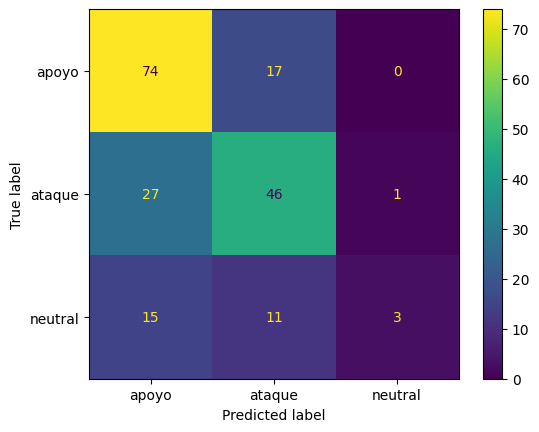

In [57]:
import matplotlib.pyplot as plt

labels = y_test.unique()

cm = confusion_matrix(y_test, preds, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot()
plt.show()

## Importancia de features

In [93]:
model.classes_

array(['apoyo', 'ataque', 'neutral'], dtype=object)

In [77]:
import shap
import matplotlib.pyplot as plt

# Create explainer and compute SHAP values
explainer = shap.TreeExplainer(model)
explanation = explainer(X_test)

In [81]:
explanation.shape

(194, 831, 3)

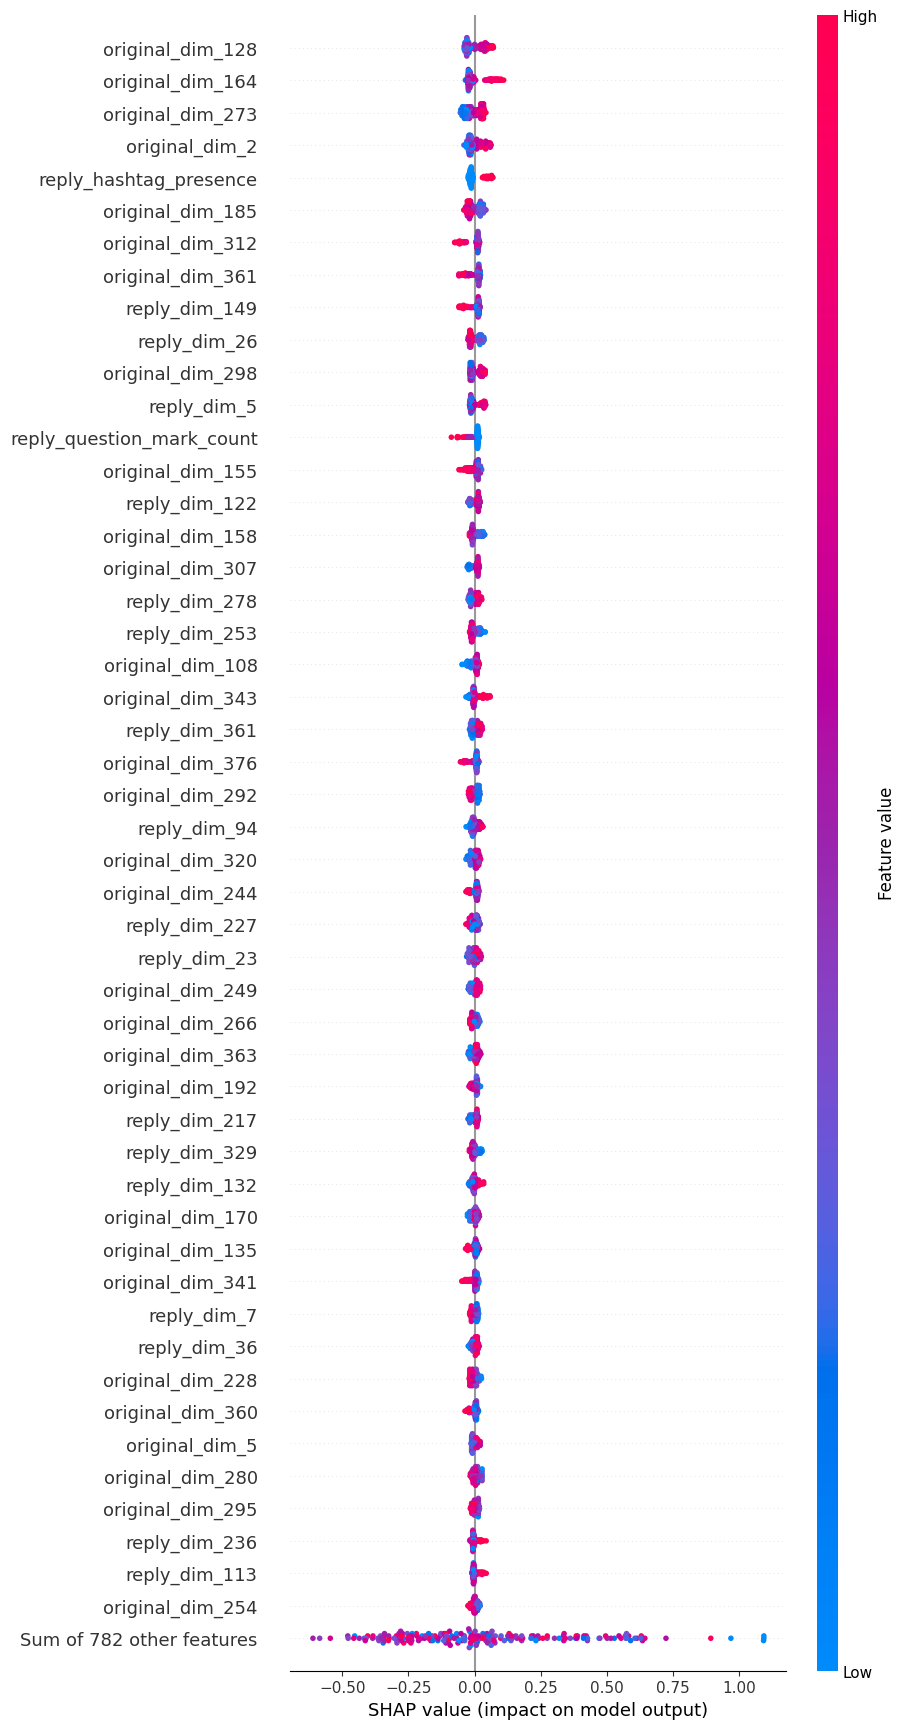

In [87]:
# Apoyo
shap.plots.beeswarm(explanation[...,0], max_display=50)

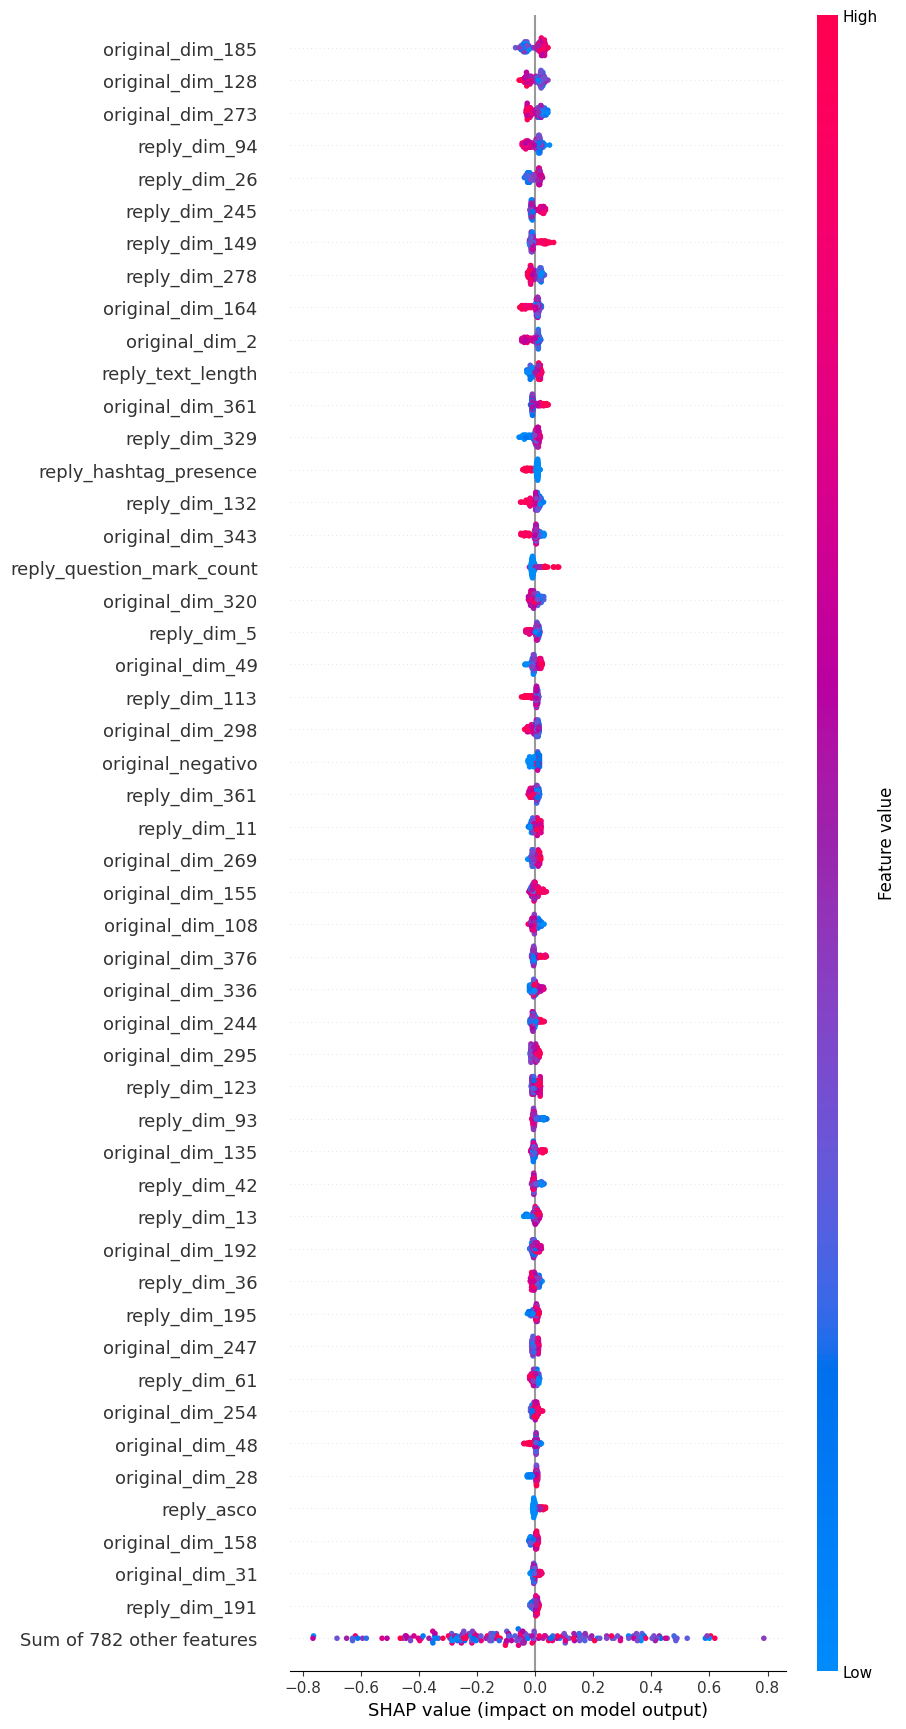

In [88]:
# Ataque
shap.plots.beeswarm(explanation[...,1], max_display=50)

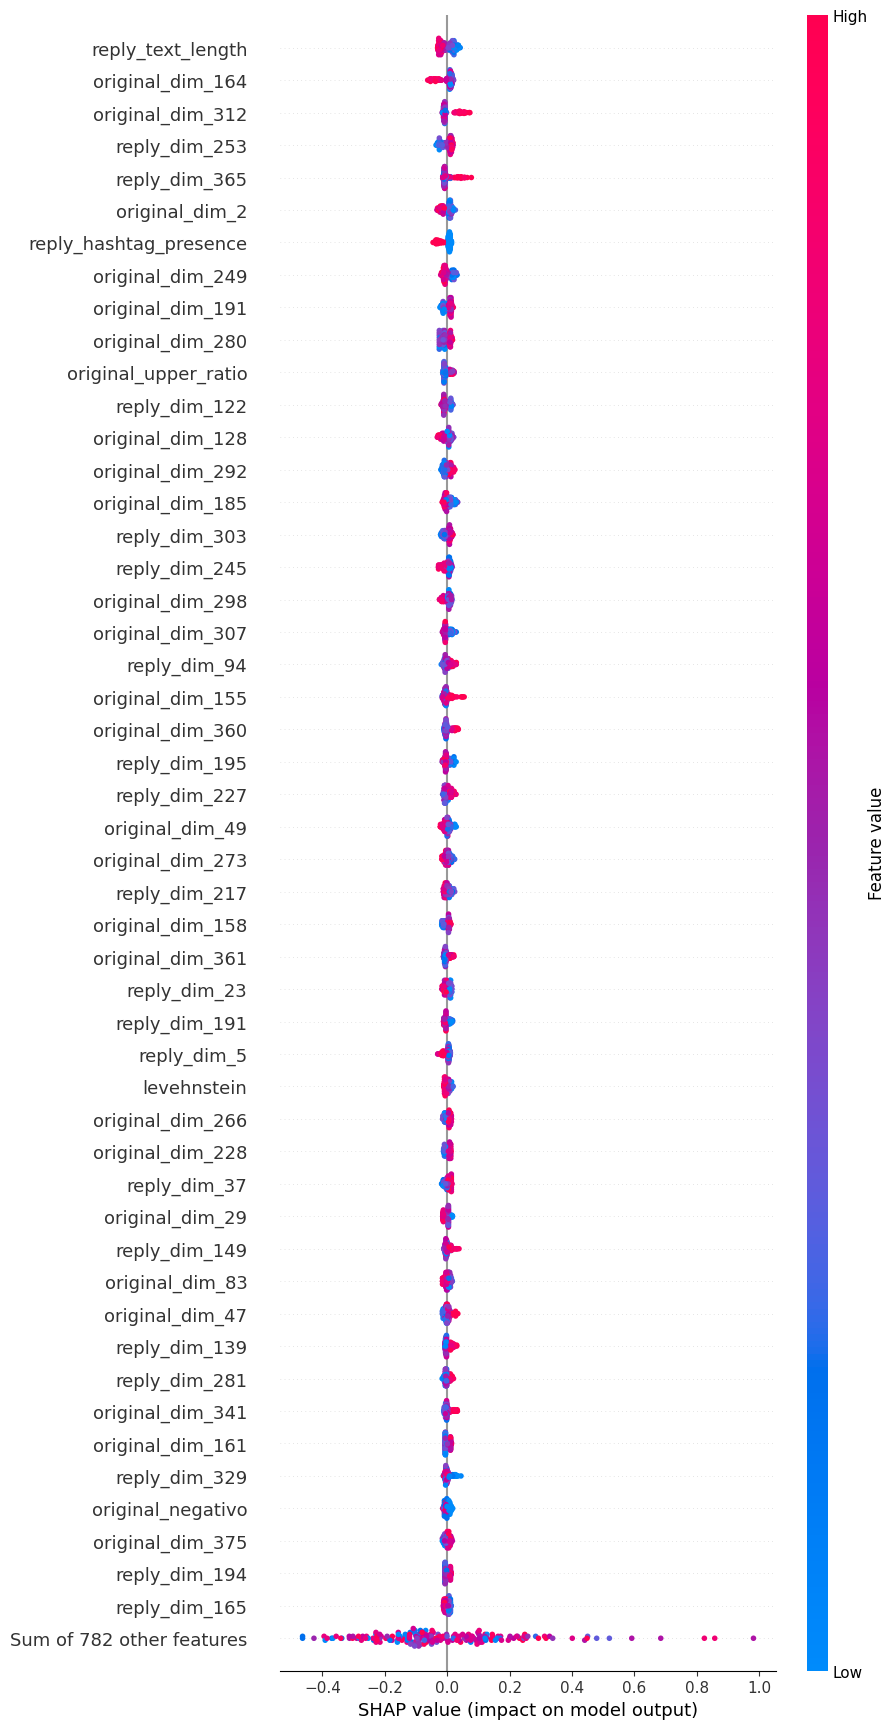

In [89]:
# Neutral
shap.plots.beeswarm(explanation[...,2], max_display=50)